In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

import random
import sklearn

from matplotlib import cm
from matplotlib.colors import ListedColormap
from copy import deepcopy
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,silhouette_score
from sklearn.cluster import KMeans

def setup_seed(seed):
    #--- Fix random seed ---#
    np.random.seed(seed)
    random.seed(seed)
seed = 1105
setup_seed(seed)

## Fig.2 Overall performance of scTranslator

- Performance of scTranslator on test dataset

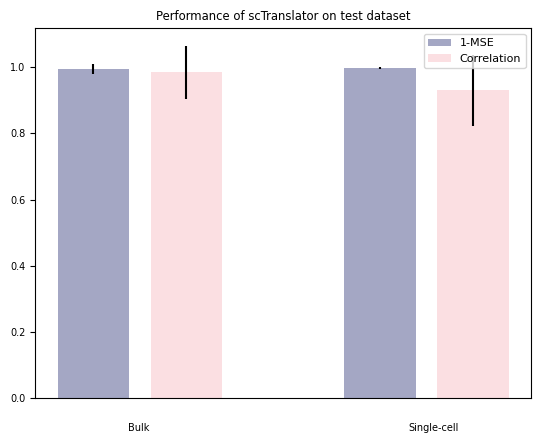

In [2]:
path = 'scTranslator/result/fig2/a/bulk_test_all.csv'
bulk_performer_all = pd.read_csv(path, sep=',')[['test_loss', 'test_ccc']]
path = 'scTranslator/result/fig2/a/single-cell_test_all.csv'
sc_performer_all = pd.read_csv(path, sep=',')[['test_loss', 'test_ccc']]

mean_mse = (1-np.mean(bulk_performer_all['test_loss']), 1-np.mean(sc_performer_all['test_loss']))
std_mse = (np.std(bulk_performer_all['test_loss']), np.std(sc_performer_all['test_loss']))
mean_ccc = (np.mean(bulk_performer_all['test_ccc']), np.mean(sc_performer_all['test_ccc']))
std_ccc = (np.std(bulk_performer_all['test_ccc']), np.std(sc_performer_all['test_ccc']))

fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.25

rects1 = ax.bar(index, mean_mse, bar_width, color='#A4A7C4',
                yerr=std_mse, label='1-MSE')

rects2 = ax.bar(index + 1.3*bar_width, mean_ccc, bar_width, color='#FBDFE2', 
                yerr=std_ccc, label='Correlation')

ax.set_title('Performance of scTranslator on test dataset')
ax.legend(loc='upper right',  fontsize=8)

plt.text(0.12, -0.1, 'Bulk')
plt.text(1.1, -0.1, 'Single-cell')
plt.xticks([])
plt.show()

- Performance of scTranslator on training dataset

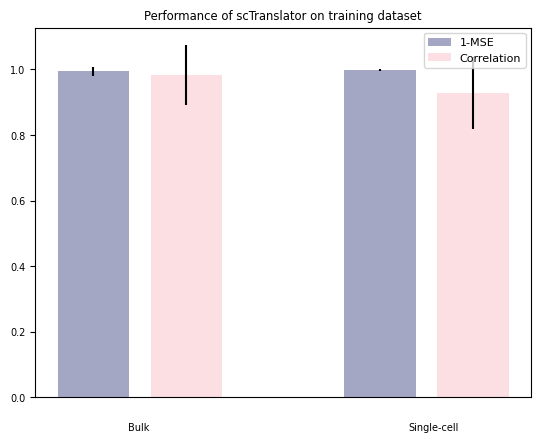

In [5]:
path = 'scTranslator/result/fig2/a/bulk_train_all.csv'
bulk_performer_all = pd.read_csv(path, sep=',')[['train_loss', 'train_ccc']]
path = 'scTranslator/result/fig2/a/single-cell_train_all.csv'
sc_performer_all = pd.read_csv(path, sep=',')[['train_loss', 'train_ccc']]

mean_mse = (1-np.mean(bulk_performer_all['train_loss']), 1-np.mean(sc_performer_all['train_loss']))
std_mse = (np.std(bulk_performer_all['train_loss']), np.std(sc_performer_all['train_loss']))
mean_ccc = (np.mean(bulk_performer_all['train_ccc']), np.mean(sc_performer_all['train_ccc']))
std_ccc = (np.std(bulk_performer_all['train_ccc']), np.std(sc_performer_all['train_ccc']))

fig, ax = plt.subplots()
index = np.arange(2)
rects1 = ax.bar(index, mean_mse, bar_width, color='#A4A7C4',
                yerr=std_mse, label='1-MSE')

rects2 = ax.bar(index + 1.3*bar_width, mean_ccc, bar_width, color='#FBDFE2', 
                yerr=std_ccc, label='Correlation')

ax.set_title('Performance of scTranslator on training dataset')
ax.legend(loc='upper right',  fontsize=8)

plt.text(0.12, -0.1, 'Bulk')
plt.text(1.1, -0.1, 'Single-cell')
plt.xticks([])
plt.show()

- Joint plots of ground truth and prediction

<Figure size 600x600 with 0 Axes>

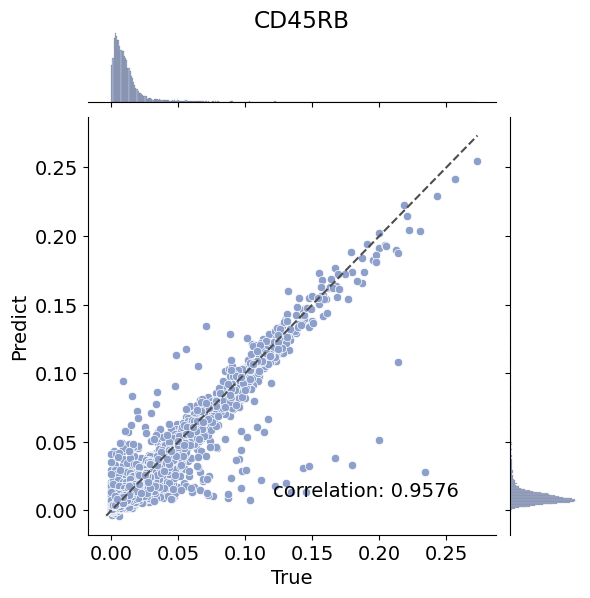

In [25]:
path = 'scTranslator/result/fig2/b/y_pred.csv'
y_hat = pd.read_csv(path, sep=',').drop(columns='Unnamed: 0')
path = 'scTranslator/result/fig2/b/y_truth.csv'
y = pd.read_csv(path, sep=',').drop(columns='Unnamed: 0')

pro =  'CD45RB'

true_value = y[pro]
imputed_value = y_hat[pro]
data = pd.DataFrame([true_value, imputed_value], index=['True','Predict']).T

correlation = (np.matmul(true_value,imputed_value))/(np.linalg.norm(true_value)*np.linalg.norm(imputed_value))

fig = plt.figure(figsize=(6, 6))
g = sns.jointplot(data=data, x='True', y='Predict', color=sns.color_palette("Set2")[2])

axmin = min(min(imputed_value),min(true_value))
axmax = max(max(imputed_value),max(true_value))
plt.plot([axmin,axmax],[axmin,axmax],ls='--',c='.3')
plt.text(0.45*(axmax-axmin)+axmin,0.05*(axmax-axmin)+axmin,'correlation: '+str(round(correlation,4)))
g.figure.suptitle(pro, verticalalignment='center')
plt.show()


- Predictability

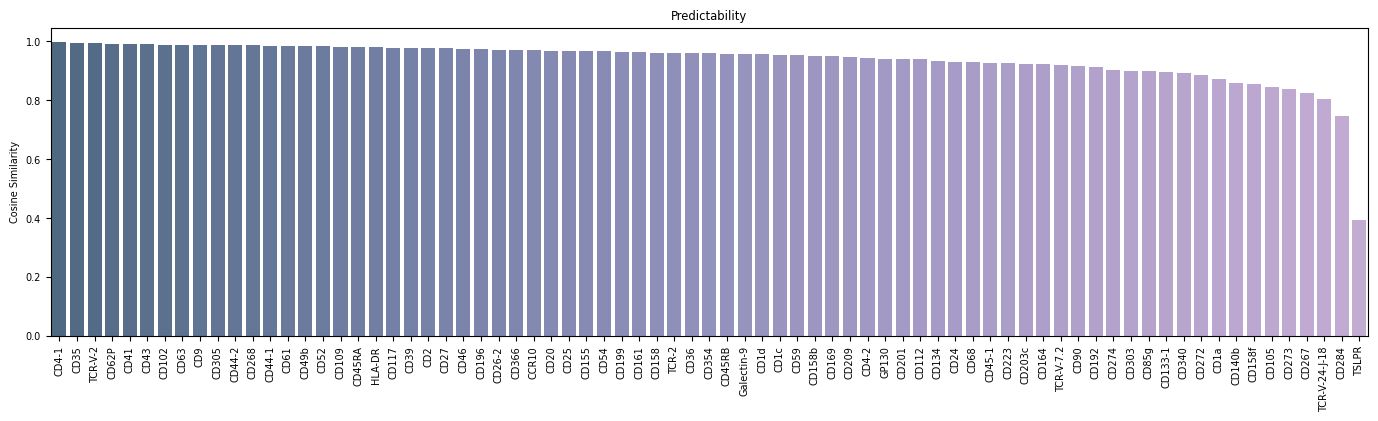

In [32]:
data = pd.DataFrame(index=y.columns, columns=['Protein', 'Predictability'])
data['Protein'] = data.index
for pro in y.columns:
    true_value = y[pro]
    imputed_value = y_hat[pro]
    data.loc[pro, 'Predictability'] = (np.matmul(true_value,imputed_value))/(np.linalg.norm(true_value)*np.linalg.norm(imputed_value))
data.sort_values('Predictability', ascending=False,inplace=True)
data.index = range(data.shape[0])
fig = plt.figure(figsize=(17,4))
color = sns.cubehelix_palette(data.shape[0]/3+1,start=2.5, rot=0.5, gamma=.5, dark=0.15, light=0.5, reverse=True)
ax = sns.barplot(data=data[data.index%3==0], x='Protein', y='Predictability', palette=color)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel('')
plt.ylabel('Cosine Similarity')
plt.title('Predictability')
plt.show()

## Fig.3 Systematic benchmarks on protein inference

- Aligned experiment

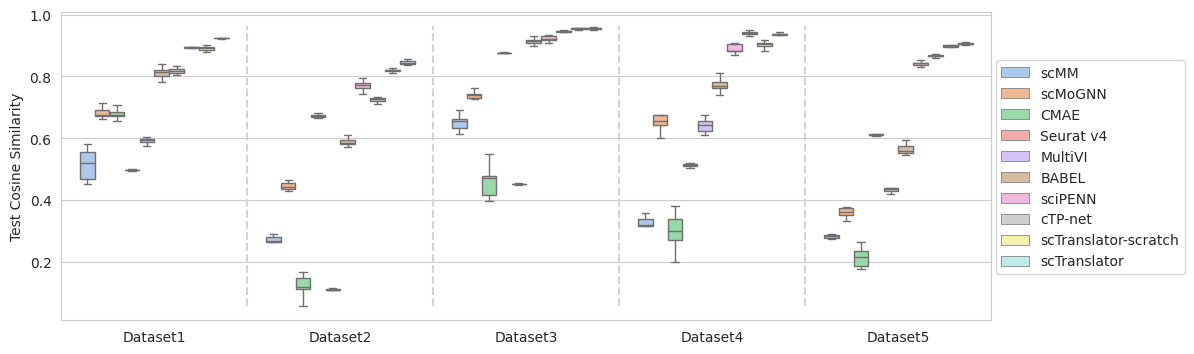

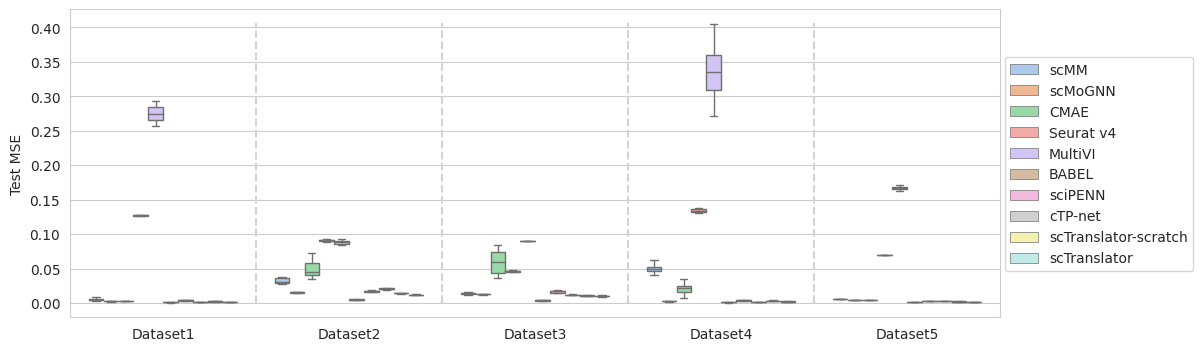

In [10]:
path = 'scTranslator/result/fig3/Systematic benchmark results.xlsx'
perform_all = pd.read_excel(path,sheet_name='Aligned experiment')

model_labels = ['scMM', 'scMoGNN', 'CMAE', 'Seurat v4', 'MultiVI', 'BABEL', 'sciPENN', 'cTP-net', 'scTranslator-scratch', 'scTranslator']
num_model = len(model_labels)
colors = sns.color_palette('pastel', num_model)
sns.set_style('whitegrid')

for metric in ['Test Cosine Similarity', 'Test MSE']:
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.boxplot(data=perform_all, x='Dataset', y=metric, hue="Model", hue_order=model_labels, palette=colors, showfliers=False, linewidth=1)
    x_start, y_start, y_end = 0.5, perform_all[metric].min().min() - 0.001, perform_all[metric].max() + 0.001
    ax.set_xlim(-0.5, 4.5)
    plt.vlines(x_start, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 1, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 2, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 3, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.legend(loc=(1.005, 0.15))
    plt.xlabel('')

- Un-aligned experiment

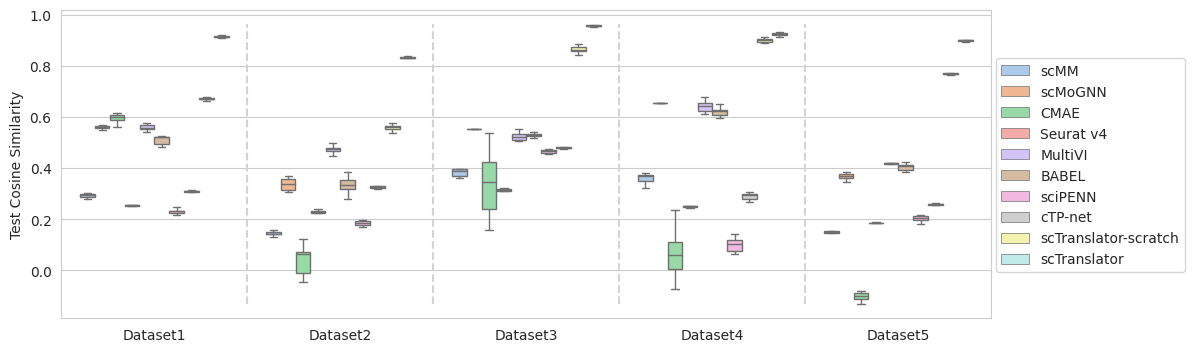

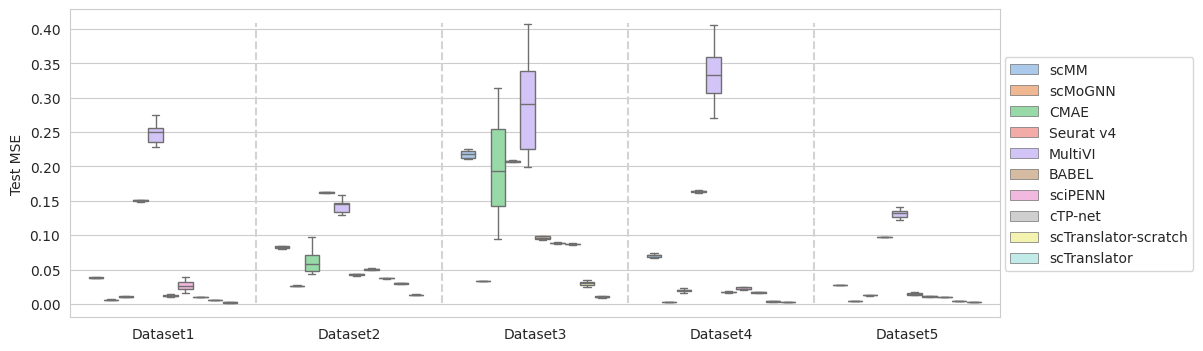

In [11]:
perform_all = pd.read_excel(path,sheet_name='Un-aligned experiment')

for metric in ['Test Cosine Similarity', 'Test MSE']:
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.boxplot(data=perform_all, x='Dataset', y=metric, hue="Model", hue_order=model_labels, palette=colors, showfliers=False, linewidth=1)
    x_start, y_start, y_end = 0.5, perform_all[metric].min().min() - 0.001, perform_all[metric].max() + 0.001
    ax.set_xlim(-0.5, 4.5)
    plt.vlines(x_start, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 1, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 2, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 3, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.legend(loc=(1.005, 0.15))
    plt.xlabel('')


- Few-shot experiment

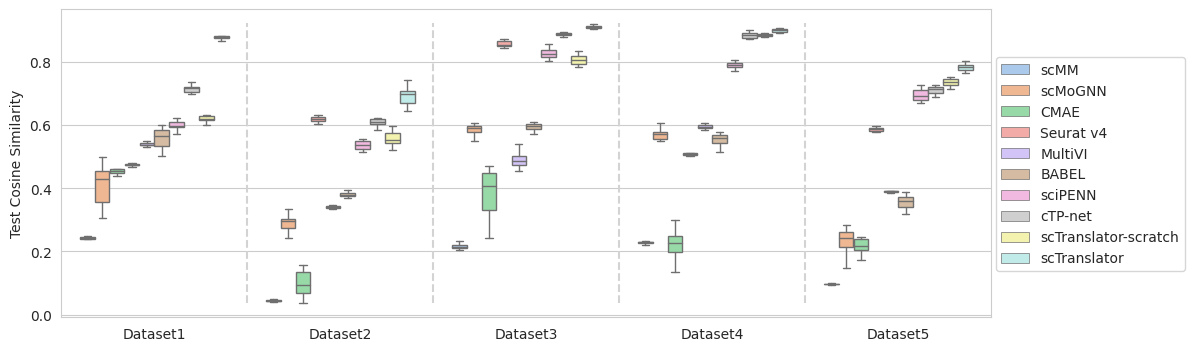

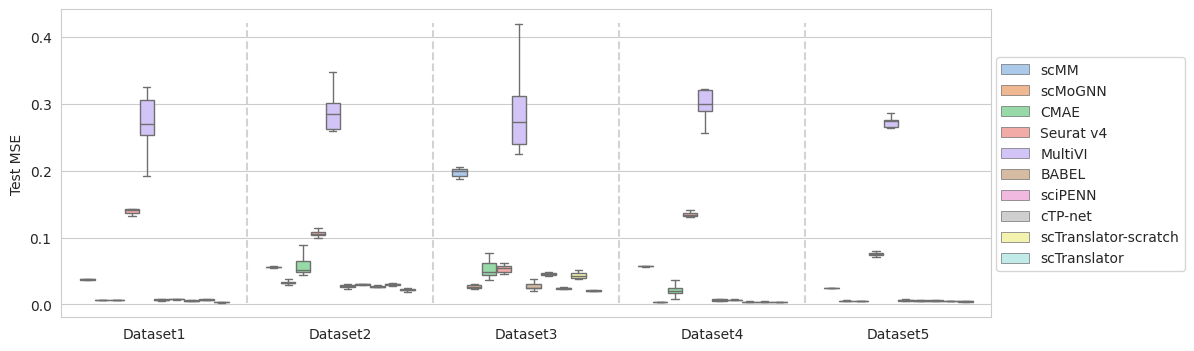

In [12]:
perform_all = pd.read_excel(path,sheet_name='Few-shot experiment')
for metric in ['Test Cosine Similarity', 'Test MSE']:
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.boxplot(data=perform_all, x='Dataset', y=metric, hue="Model", hue_order=model_labels, palette=colors, showfliers=False, linewidth=1)
    x_start, y_start, y_end = 0.5, perform_all[metric].min().min() - 0.001, perform_all[metric].max() + 0.001
    ax.set_xlim(-0.5, 4.5)
    plt.vlines(x_start, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 1, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 2, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.vlines(x_start + 3, y_start, y_end, colors='lightgray', linestyles='dashed')
    plt.legend(loc=(1.005, 0.15))
    plt.xlabel('')


## Fig.4 Integrative regulatory inference by model interpretability and pseudo-knockout

- Heatmap of attention matrix between RNA and protein.

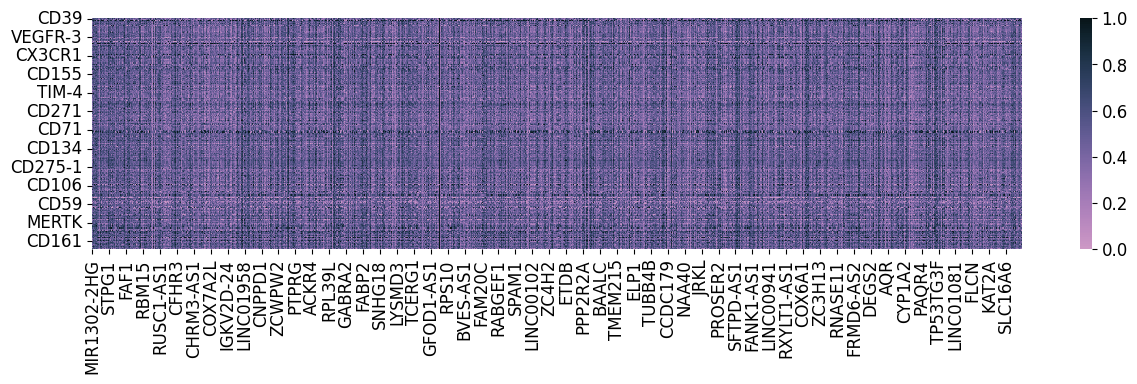

In [4]:
path = 'scTranslator/result/fig4/a/encoder2decoder_attention_score.csv'
weights = pd.read_csv(path, sep=',')
weights.index = weights['Unnamed: 0'].values
weights = weights.drop(columns='Unnamed: 0')

fig = plt.figure(figsize=(15,3))
color = sns.cubehelix_palette(16,start=2.5, rot=0.5, gamma=.9, dark=0.05, light=0.65, as_cmap=True)
sns.heatmap(weights.T, cmap=color)
plt.show()

- zoom in attention matrix obtained from encoder to decoder 

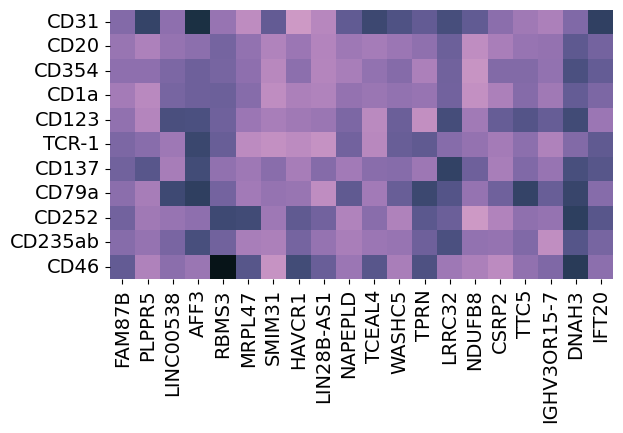

In [33]:
fig = plt.figure(figsize=(6.5,3.5))
n_g = 1000
n_p = 20
# sns.heatmap(weights.iloc[::n_g,::n_p].T, cmap=color, cbar=False)
sns.heatmap(weights.iloc[5::n_g,5::n_p].T, cmap=color, cbar=False)
plt.show()

- Potential regulation gene

In [75]:
percent = 0.05
regulation_gene = weights.sum(axis=1).sort_values(ascending=False).index[:int(weights.shape[0]*percent)]

- Top focused gene by TCR

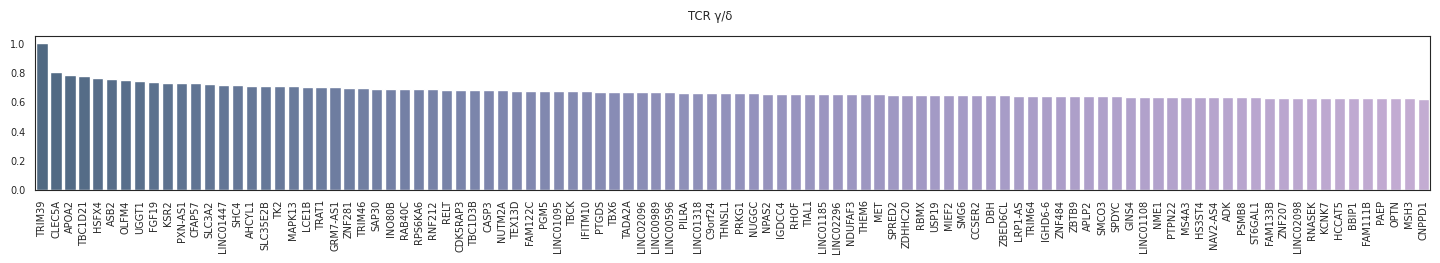

In [6]:
pro_index = 'TCR-1'
n=10
top_protein = 100
x = weights[pro_index].sort_values(ascending=False).index[:n*top_protein]
y = weights[pro_index].sort_values(ascending=False).values[:n*top_protein]
sns.set_style('white')
fig = plt.figure(figsize=(18,2))
color = sns.cubehelix_palette(top_protein,start=2.5, rot=0.5, gamma=.5, dark=0.15, light=0.5, reverse=True)
ax = sns.barplot(x=x[::n], y=y[::n], palette=color)
ax.figure.suptitle('TCR '+chr(947)+'/'+chr(948), verticalalignment='center')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

- Heatmap of attention matrix between RNA and RNA.

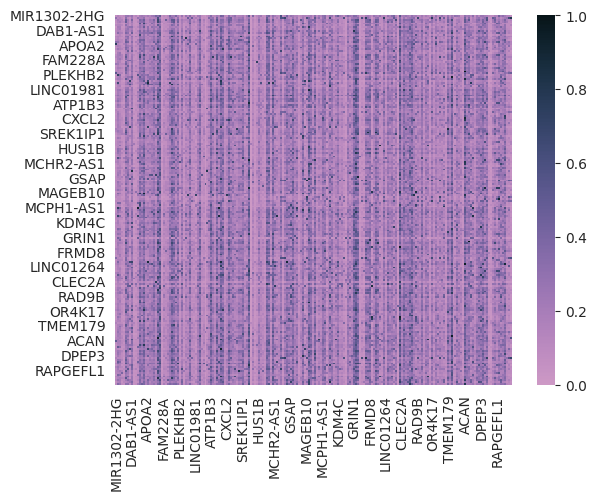

In [14]:
path = 'scTranslator/result/fig4/a/encoder_attention_score.csv'
weights = pd.read_csv(path, sep=',').drop(columns='Unnamed: 0')
weights.index = weights.columns
subweights=weights.iloc[::100,::100]
fig = plt.figure()
color = sns.cubehelix_palette(16,start=2.5, rot=0.5, gamma=.9, dark=0.05, light=0.65, as_cmap=True)
sns.heatmap(subweights, cmap=color)
plt.show()

- Heatmap of attention matrix between Protein and Protein.

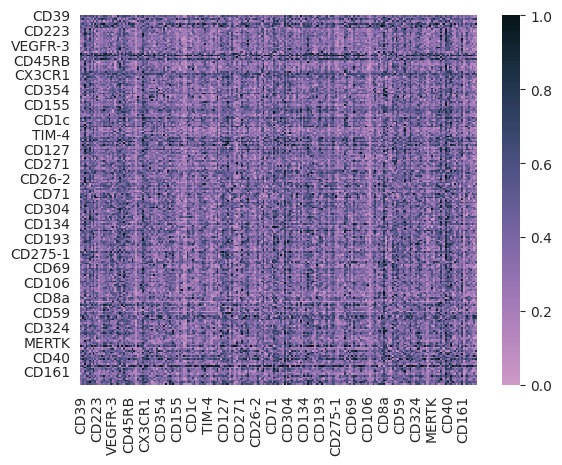

In [15]:
path = 'scTranslator/result/fig4/a/decoder_attention_score.csv'
weights = pd.read_csv(path, sep=',').drop(columns='Unnamed: 0')
weights.index = weights.columns

fig = plt.figure()
color = sns.cubehelix_palette(16,start=2.5, rot=0.5, gamma=.9, dark=0.05, light=0.65, as_cmap=True)
sns.heatmap(weights, cmap=color)
plt.show()

- Results of pseudo-knockout

In [17]:
path = 'scTranslator/result/fig4/c/knock_out_org.pkl'
org = pd.read_pickle(path)

Text(0, 0.5, 'Protein abundance changes')

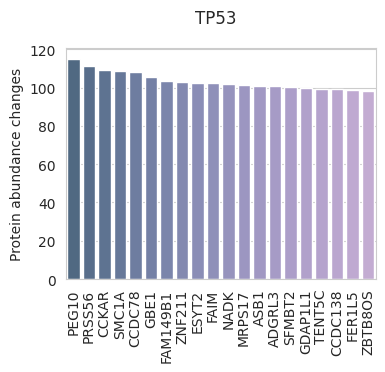

In [18]:
gene_index = 'TP53'
plt.rcParams['font.size'] = 10
path = 'scTranslator/result/fig4/c/knock_out_'+gene_index+'.pkl'
knocked = pd.read_pickle(path)

start, top_protein = 0, 20
delta = pd.DataFrame((knocked.sum()-org.sum()).values, columns=['org_value'], index=knocked.columns)
delta['abs_value'] = abs(delta['org_value'])

x = delta['abs_value'].sort_values(ascending=False).index[start:start+top_protein]
y = delta.loc[x,'abs_value']
fig = plt.figure(figsize=(4,3))
color = sns.cubehelix_palette(top_protein,start=2.5, rot=0.5, gamma=.5, dark=0.15, light=0.5, reverse=True)
ax = sns.barplot(x=x, y=y, palette=color)

ax.figure.suptitle(gene_index, verticalalignment='center')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylabel('Protein abundance changes')


## Fig.5 Exploration of cell heterogeneity in PBMCs and cell origin in pan-cancer data

- UMAP visualization of true protein colored by cell type and batch information

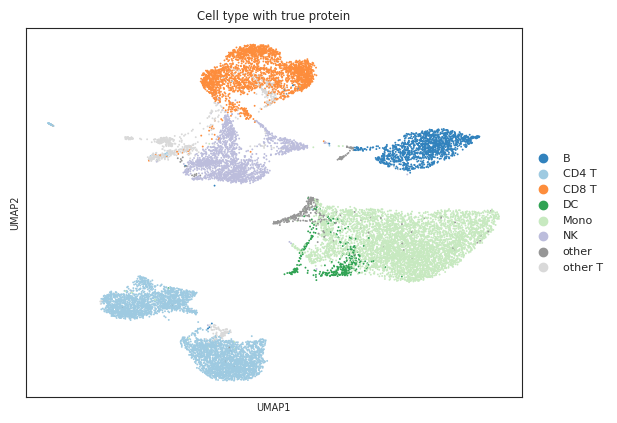

In [9]:
data_path = 'scTranslator/result/fig5/seuratv4_finetune_true_scP_adata.h5ad'
true_adata = sc.read_h5ad(data_path)
ax = sc.pl.umap(true_adata, color=['celltype.l1'], legend_fontsize=8, palette='tab20c', show=False)
ax.set_title('Cell type with true protein')
plt.show()

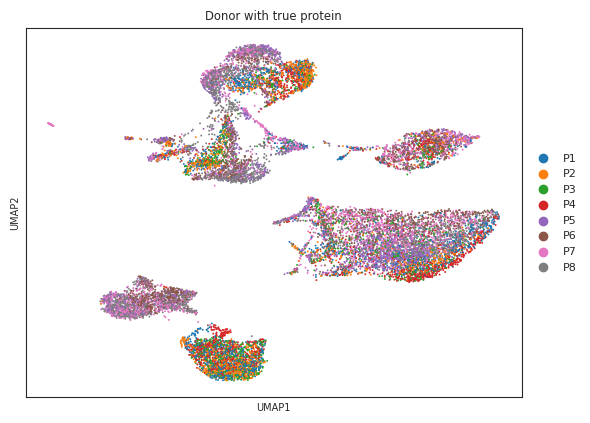

In [10]:
ax = sc.pl.umap(true_adata, color=['donor'], legend_fontsize=8, show=False)
ax.set_title('Donor with true protein')
plt.show()

- UMAP visualization of predicted protein colored by cell type and batch information

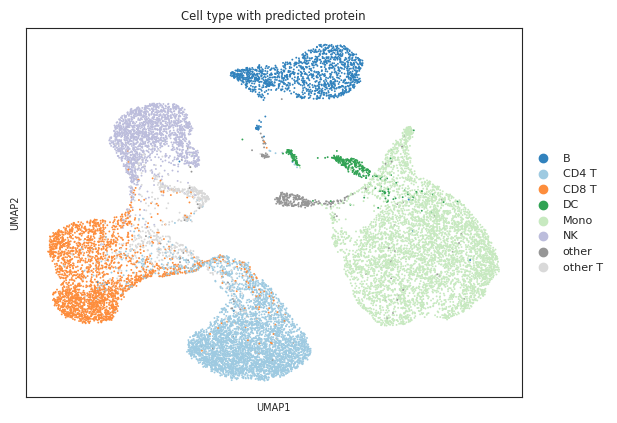

In [11]:
data_path = 'scTranslator/result/fig5/seuratv4_finetune_pred_scP_adata.h5ad'
pro_adata = sc.read_h5ad(data_path)
ax = sc.pl.umap(pro_adata, color=['celltype.l1'], legend_fontsize=8, palette='tab20c', show=False)
ax.set_title('Cell type with predicted protein')
plt.show()


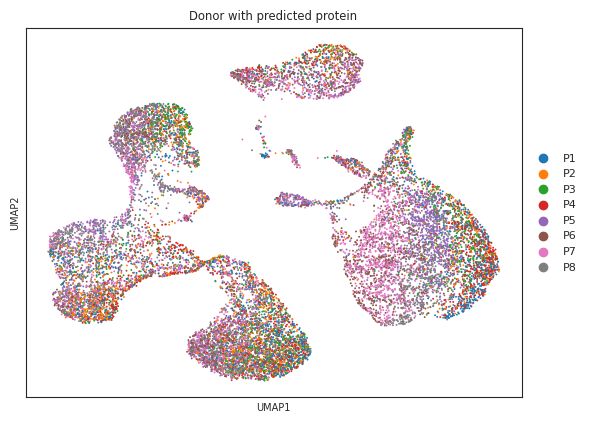

In [12]:
ax = sc.pl.umap(pro_adata, color=['donor'], legend_fontsize=8, show=False)
ax.set_title('Donor with predicted protein')
plt.show()

- UMAP visualization of predicted protein colored by cell type and batch information

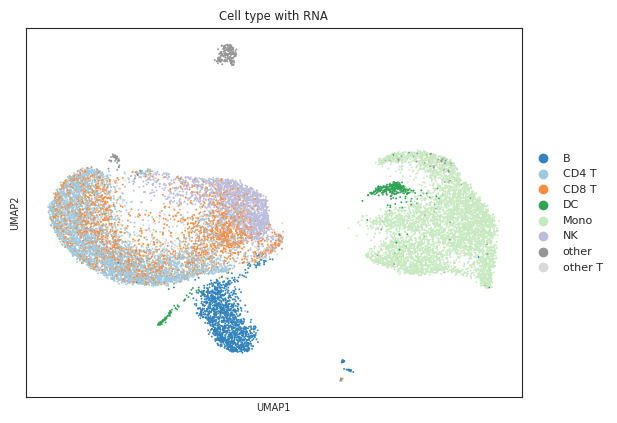

In [13]:
data_path = 'result/fig5/seuratv4_finetune_scRNA_adata.h5ad'
rna_adata = sc.read_h5ad(data_path)
ax = sc.pl.umap(rna_adata, color=['celltype.l1'], legend_fontsize=8, palette='tab20c', show=False)
ax.set_title('Cell type with RNA')
plt.show()

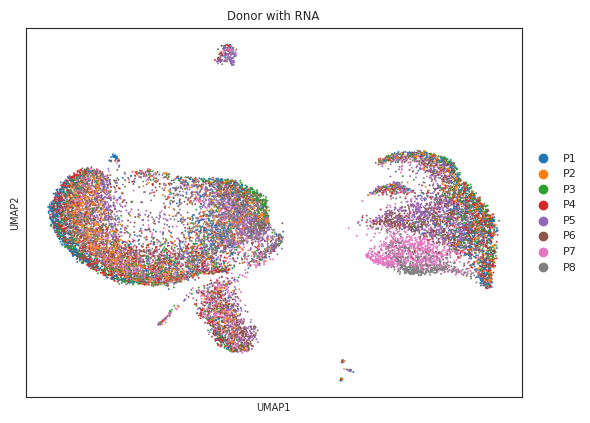

In [14]:
ax = sc.pl.umap(rna_adata, color=['donor'], legend_fontsize=8, show=False)
ax.set_title('Donor with RNA')
plt.show()

- Maker identification for different cell types

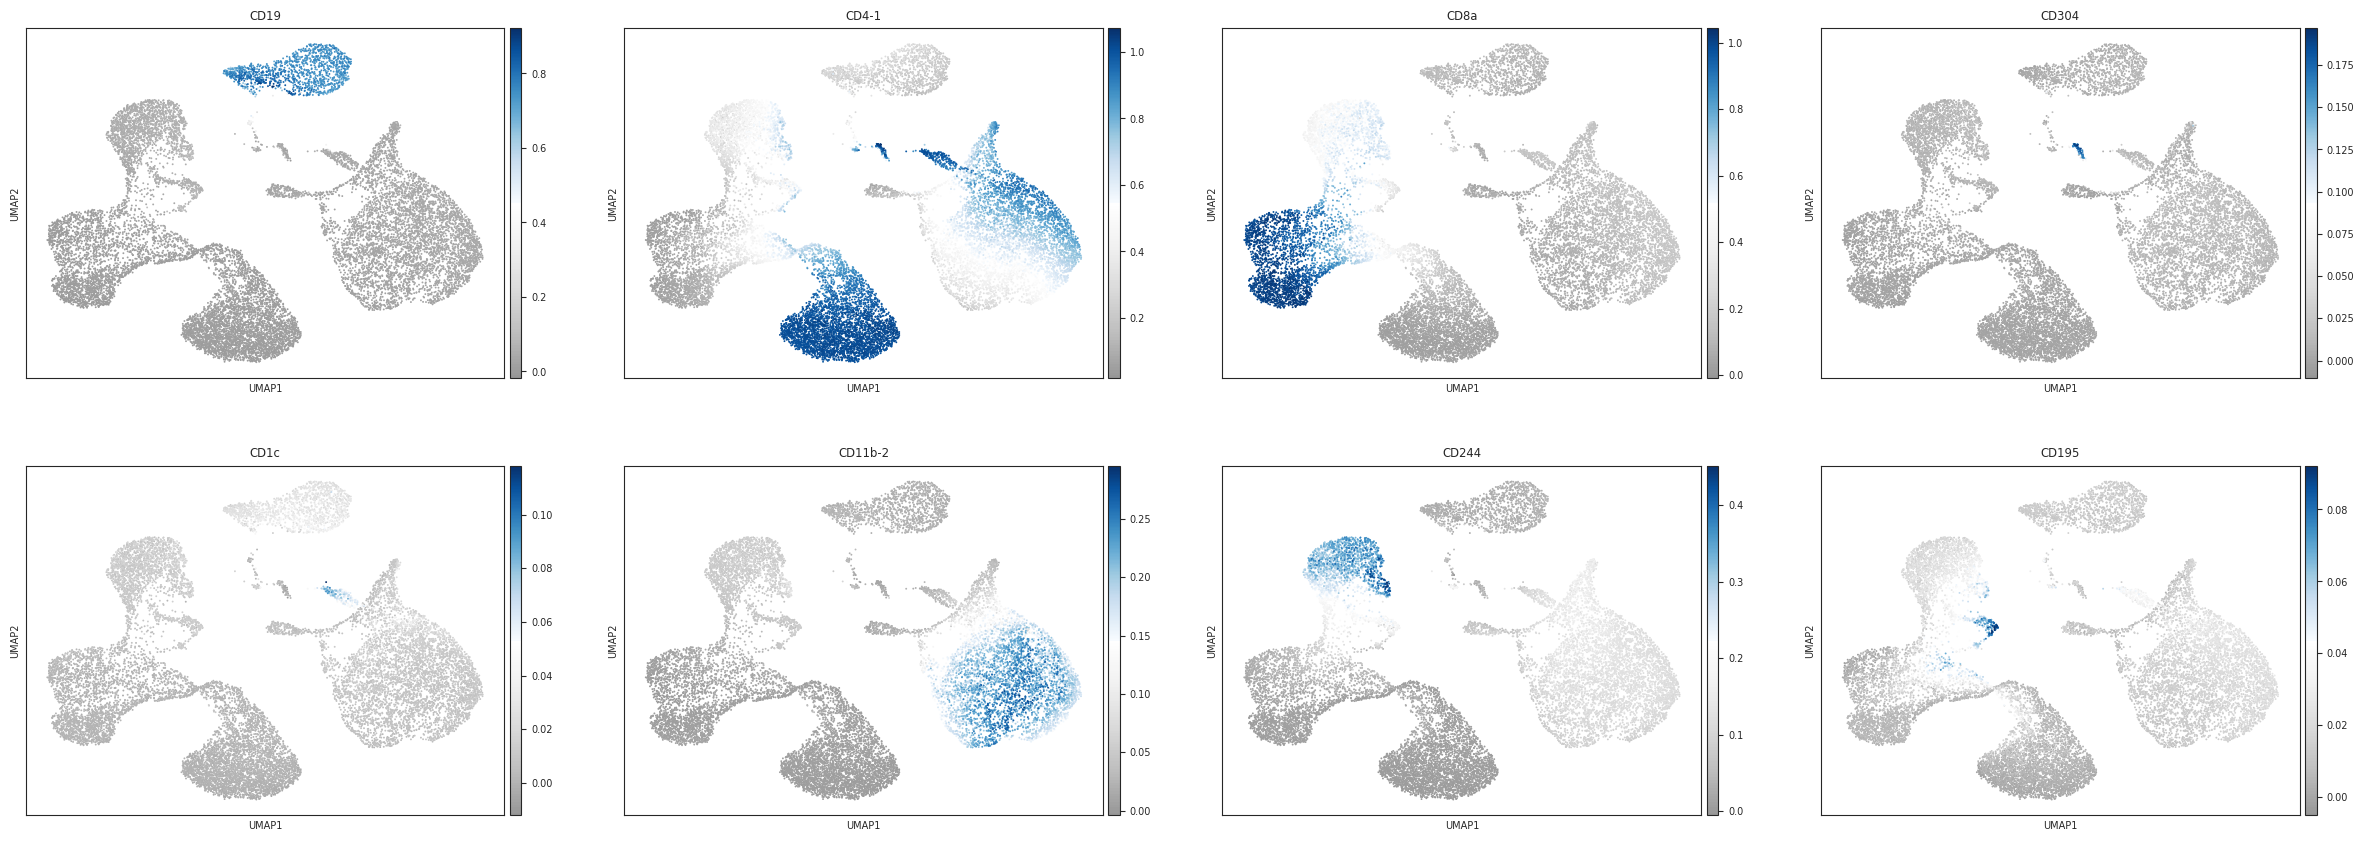

In [15]:
num_color = 128
top = cm.get_cmap('Greys_r', num_color)
bottom = cm.get_cmap('Blues', num_color)
newcolors = np.vstack((top(np.linspace(0.5, 1, num_color)),
                       bottom(np.linspace(0, 1, num_color))))
newcmp = ListedColormap(newcolors)

gene_list = ['CD19', 'CD4-1', 'CD8a', 'CD304', 'CD1c', 'CD11b-2', 'CD244', 'CD195']
sc.pl.umap(pro_adata, color=[i for i in gene_list], color_map=newcmp, legend_fontsize=8) 

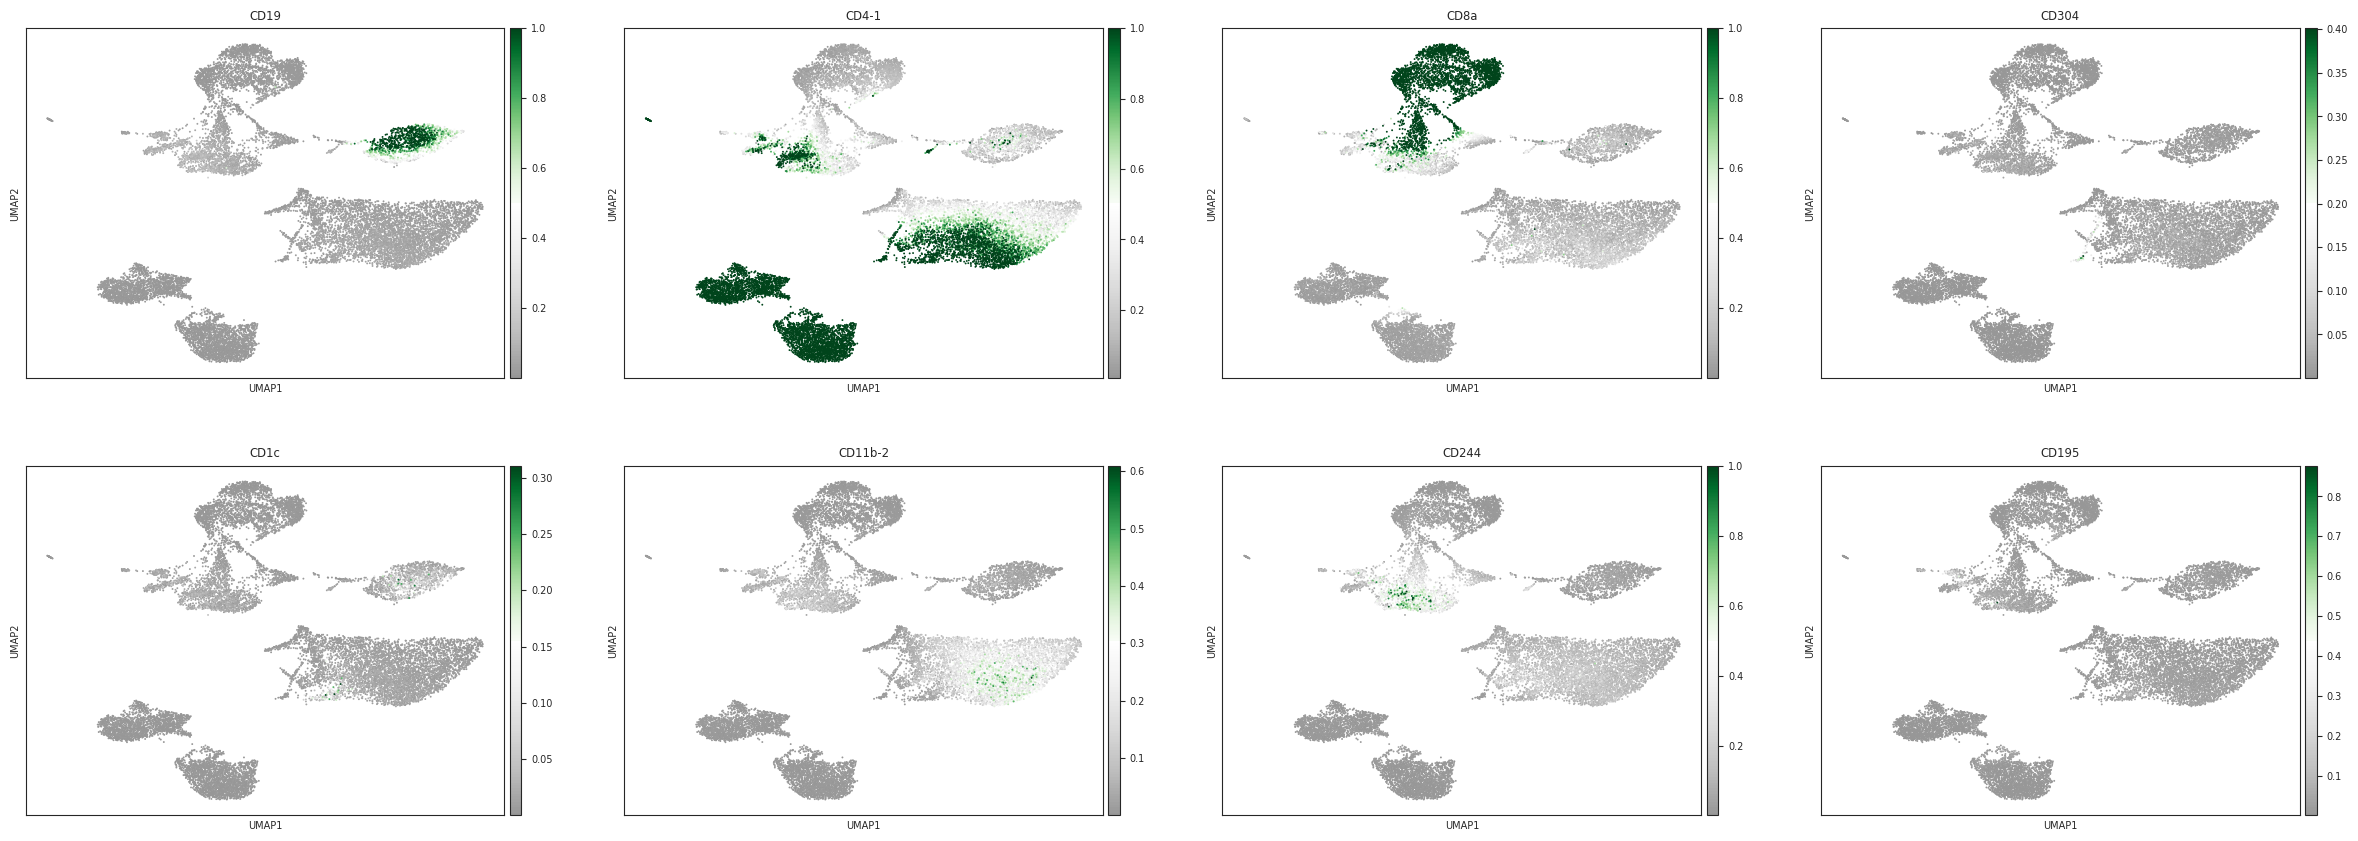

In [16]:
bottom = cm.get_cmap('Greens', num_color)
newcolors = np.vstack((top(np.linspace(0.5, 1, num_color)),
                       bottom(np.linspace(0, 1, num_color))))
newcmp = ListedColormap(newcolors)
sc.pl.umap(true_adata, color=[i for i in gene_list], color_map=newcmp, legend_fontsize=8) 

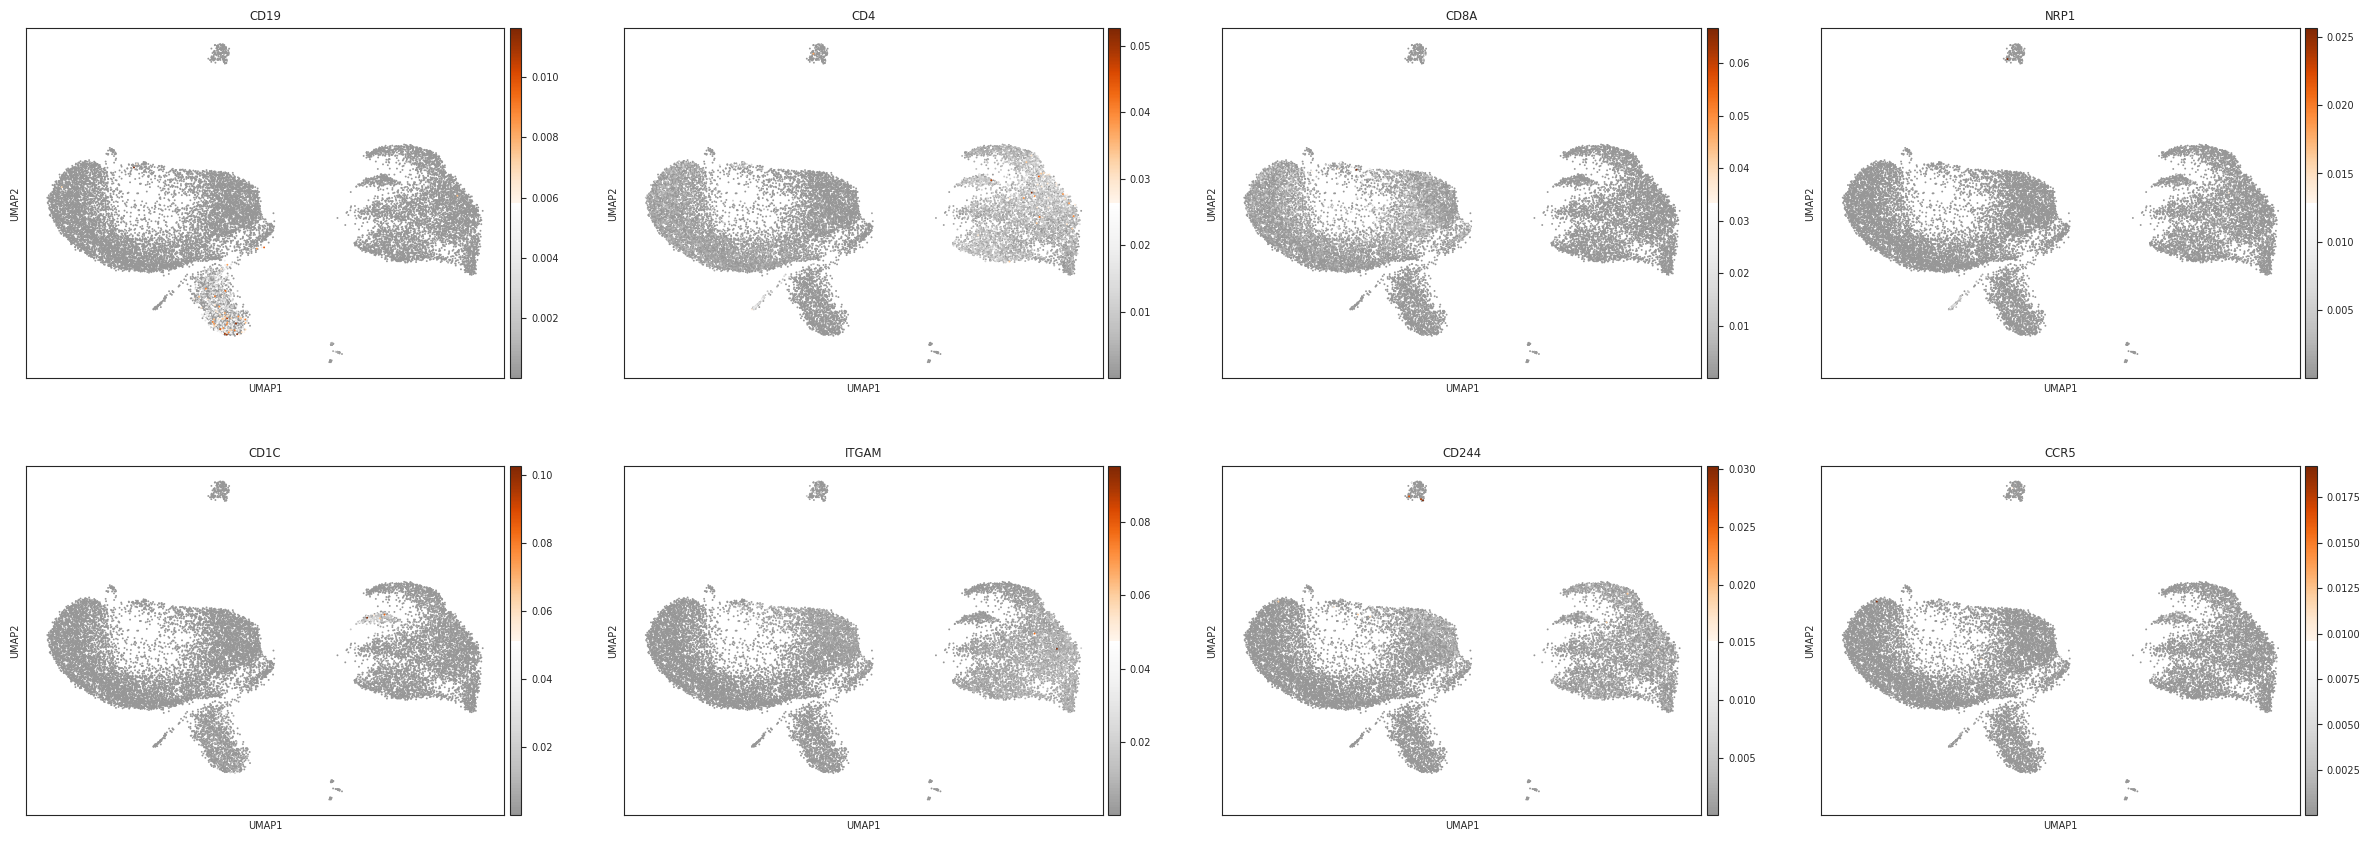

In [17]:
bottom = cm.get_cmap('Oranges', num_color)
newcolors = np.vstack((top(np.linspace(0.5, 1, num_color)),
                       bottom(np.linspace(0, 1, num_color))))
newcmp = ListedColormap(newcolors)

ID = 'Entrez_Gene_Id'
gene_list_rna = [rna_adata.var[rna_adata.var[ID].values==j].index[0] for j in pro_adata.var.loc[gene_list,ID].values if j in rna_adata.var[ID].values]
gene_list_rna.insert(5, 'ITGAM')
sc.pl.umap(rna_adata, color=[i for i in gene_list_rna], color_map=newcmp, legend_fontsize=8) 

- Performance of cell clustering

In [18]:
n_clusters = 8
level = 'l1'
label_level = 'celltype.'+level

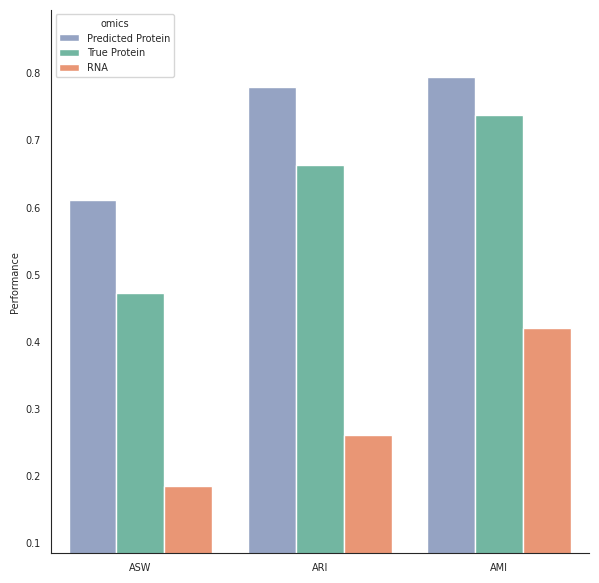

In [19]:
# True protein
adata = deepcopy(true_adata)
label_enc = preprocessing.LabelEncoder()
labels_true = label_enc.fit_transform(adata.obs[label_level].values)
kmeans = KMeans(n_clusters=8).fit(adata.X)
adata.obs['cluster'] = kmeans.labels_
ARI = np.round(adjusted_rand_score(labels_true, adata.obs['cluster']), 4)
AMI = np.round(adjusted_mutual_info_score(labels_true, adata.obs['cluster']), 4)
ASW = np.round(silhouette_score(adata.X, adata.obs['cluster']), 4)
truth_result = ['True Protein', ARI, AMI, ASW]

# Predicted protein
adata = deepcopy(pro_adata)
kmeans = KMeans(n_clusters=8).fit(adata.X)
adata.obs['cluster'] = kmeans.labels_
ARI = np.round(adjusted_rand_score(labels_true, adata.obs['cluster']), 4)
AMI = np.round(adjusted_mutual_info_score(labels_true, adata.obs['cluster']), 4)
ASW = np.round(silhouette_score(adata.X, adata.obs['cluster']), 4) 
pred_result = ['Predicted Protein', ARI, AMI, ASW]

# RNA
adata = deepcopy(rna_adata)
kmeans = KMeans(n_clusters=8).fit(adata.X)
adata.obs['cluster'] = kmeans.labels_
ARI = np.round(adjusted_rand_score(labels_true, adata.obs['cluster']), 4)
AMI = np.round(adjusted_mutual_info_score(labels_true, adata.obs['cluster']), 4)
ASW = np.round(silhouette_score(adata.X, adata.obs['cluster']), 4) 
RNA_result = ['RNA', ARI, AMI, ASW]

log = pd.DataFrame([pred_result, truth_result, RNA_result], columns=['Omics', 'ARI', 'AMI', 'ASW'])
log_plot = pd.DataFrame(columns = ['omics', 'metric', 'performance'])
metic_list = ['ASW', 'ARI', 'AMI']
for i in range(len(log)):
    omics = log.iloc[i]['Omics']
    for (metric, j) in zip(metic_list, log.iloc[i][metic_list]):
        log_plot.loc[len(log_plot)] = [omics, metric, j]

# plotting
color = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[0],sns.color_palette("Set2")[1]]
g = sns.catplot(data=log_plot, x='metric', y='performance', kind="bar", hue="omics", errorbar="sd", palette=color, alpha=1, height=6, legend_out=False)
g.set_axis_labels('',"Performance")

plt.ylim(min(log_plot['performance'])-0.1,max(log_plot['performance'])+0.1)
plt.show()

- Performance of batch correction

In [20]:
def batch_clus(tsne,label,batch):
    ncell = len(label)
    Kb = len(np.unique(batch))
    unique_celltype = np.unique(label) 
    tsnesil,tsneari,tsneami= 0,0,0
    for i in unique_celltype:
        kmeans_tsne = KMeans(n_clusters=Kb).fit(
                (tsne[label==i,:]))
        clusterlabel_tsne = kmeans_tsne.labels_
        tsnesil = tsnesil + silhouette_score(tsne[label==i,:],batch[label==i])*np.sum(label==i)
        tsneami = tsneami + adjusted_mutual_info_score(batch[label==i],clusterlabel_tsne)*np.sum(label==i)
        tsneari = tsneari + adjusted_rand_score(batch[label==i],clusterlabel_tsne)*np.sum(label==i)
    ASW = np.round(1-tsnesil/ncell,4)
    ARI =np.round(1-tsneari/ncell,4)
    AMI = np.round(1-tsneami/ncell,4)
    return ASW, ARI, AMI

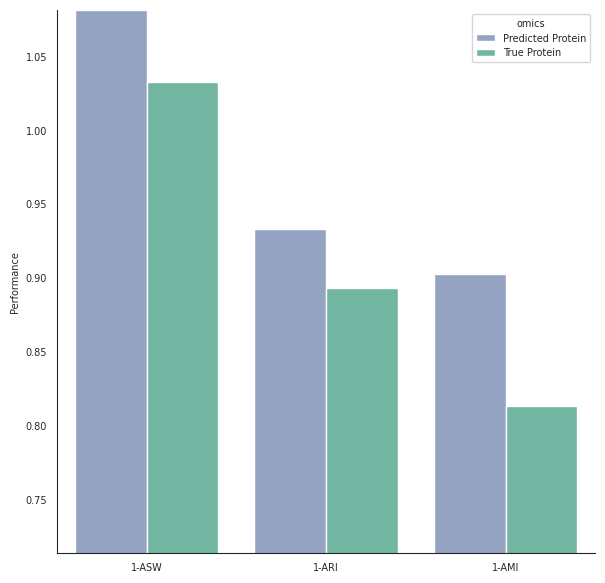

In [21]:
# True protein
adata = deepcopy(true_adata)
label_enc = preprocessing.LabelEncoder()
labels_true = label_enc.fit_transform(adata.obs[label_level].values)
batch = label_enc.fit_transform(adata.obs['donor'].values)
ASW, ARI, AMI = batch_clus(adata.X, labels_true, batch)
truth_result = ['True Protein', ARI, AMI, ASW]

# Predicted protein
adata = deepcopy(pro_adata)
kmeans = KMeans(n_clusters=8).fit(adata.obsm['X_pca'])
adata.obs['cluster'] = kmeans.labels_
ASW, ARI, AMI = batch_clus(adata.X, labels_true, batch)
pred_result = ['Predicted Protein', ARI, AMI, ASW]


log = pd.DataFrame([pred_result, truth_result], columns=['Omics', 'ARI', 'AMI', 'ASW'])
log_plot = pd.DataFrame(columns = ['omics', 'metric', 'performance'])
metic_list = ['ASW', 'ARI', 'AMI']
for i in range(len(log)):
    omics = log.iloc[i]['Omics']
    for (metric, j) in zip(metic_list, log.iloc[i][metic_list]):
        metric = '1-'+metric
        log_plot.loc[len(log_plot)] = [omics, metric, j]

# plotting
color = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[0],sns.color_palette("Set2")[1]]
g = sns.catplot(data=log_plot, x='metric', y='performance', kind="bar", hue="omics", errorbar="sd", palette=color, alpha=1, height=6, legend_out=False)
g.set_axis_labels('',"Performance")
plt.ylim(min(log_plot['performance'])-0.1,max(log_plot['performance']))
plt.show()

- Cell origin recognition on pan-cancer data

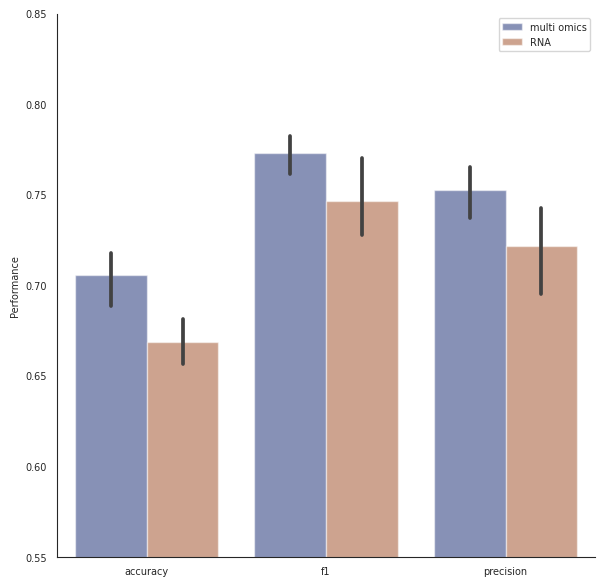

In [22]:
data = pd.read_csv('scTranslator/result/fig5/tumor_nontumor.csv')
g = sns.catplot(data=data, x='metric', y='performance', kind="bar", hue="omics", palette="dark", alpha=.5, height=6, legend_out=False)
g.set_axis_labels("","Performance")
g.legend.set_title("")
plt.ylim(0.55,0.85)
plt.show()